In [1]:
# Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!apt-get -y install fonts-ipafont-gothic
!pip install seaborn japanize_matplotlib
!pip install scipy==1.13.0
!pip install stumpy tsfresh --use-deprecated=legacy-resolver
!pip install optuna
!pip -q install pydrive2 openpyxl
! pip install pyarrow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [3]:
! pip install pyarrow

In [4]:
import pandas as pd
import numpy as np
import os
import glob
import re
from tqdm import tqdm
from datetime import datetime, timedelta
import pickle
import gdown

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
output_path = '/content/drive/MyDrive/isuzu_input'

In [6]:
import psutil, os, platform
mem = psutil.virtual_memory()
print(platform.platform())
print(f"Total: {mem.total/1024**3:.2f} GB, Available: {mem.available/1024**3:.2f} GB")
import pandas as pd
pd.set_option('mode.copy_on_write', True)  # pandas 2.x

Linux-6.6.97+-x86_64-with-glibc2.35
Total: 50.99 GB, Available: 49.56 GB


In [ ]:
from google.colab import auth
auth.authenticate_user()

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# ===== 設定 =====
folder_url = "https://drive.google.com/drive/u/2/folders/1IZydg442lhKMuxL0bn3u1eel9FYLrIWo"
folder_id = folder_url.rstrip("/").split("/")[-1]

expected_files = {
    "家庭用202101-202312得意先別出荷": None,
    "家庭用202401-202506得意先別出荷": None,
    "業務用202401-202506得意先別出荷": None,
    "業務用202101-202312得意先別出荷": None,
}

download_dir = "/content/yamasa_tmp"
os.makedirs(download_dir, exist_ok=True)

# 出力先（未定義なら MyDrive 直下）
try:
    output_path
except NameError:
    output_path = "/content/drive/MyDrive/isuzu_input"
os.makedirs(output_path, exist_ok=True)

# ===== フォルダを再帰的に探索して4ファイルを取得 =====
def list_files_recursive(folder_id):
    """フォルダ配下（サブフォルダ含む）のすべてのファイルメタを返す"""
    items = []
    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
    for f in file_list:
        if f['mimeType'] == 'application/vnd.google-apps.folder':
            items.extend(list_files_recursive(f['id']))
        else:
            items.append(f)
    return items

all_files = list_files_recursive(folder_id)

# タイトル（拡張子含む）から一致するものを拾う
targets = {}
for f in all_files:
    title = f['title']  # 例: "家庭用202101-202312得意先別出荷.xlsx"
    base, ext = os.path.splitext(title)
    if base in expected_files and ext.lower() == ".xlsx":
        targets[base] = f

missing = [k for k in expected_files.keys() if k not in targets]
if missing:
    print("[WARN] 見つからないファイル:", missing)
if not targets:
    raise FileNotFoundError("指定4ファイルが見つかりませんでした。フォルダ内の配置や拡張子をご確認ください。")

# ===== ダウンロード =====
local_paths = {}
for base, f in targets.items():
    local = os.path.join(download_dir, f['title'])
    f.GetContentFile(local)  # ダウンロード
    local_paths[base] = local
    print(f"[DL] {f['title']} -> {local}")

# ===== 読み込み＆前処理 =====
jp_cols = [
    "出荷日","品番","品名","店番","出荷数","曜日（月=1）","週番号",
    "品目階層1","品目階層2","品目階層3","容量","容器"
]

rename_map = {
    "出荷日": "file_date",
    "品番": "product_key",
    "品名": "product_name",
    "店番": "store_code",
    "出荷数": "actual_value",
    "曜日（月=1）": "day_of_week_mon1",
    "週番号": "week_number",
    "品目階層1": "category_lvl1",
    "品目階層2": "category_lvl2",
    "品目階層3": "category_lvl3",
    "容量": "volume",
    "容器": "container",
}

def parse_excel_date(series: pd.Series) -> pd.Series:
    """文字/日付/Excelシリアル混在を安全に datetime へ"""
    s = series.copy()
    dt1 = pd.to_datetime(s, errors="coerce")
    num = pd.to_numeric(s, errors="coerce")
    dt2 = pd.to_datetime(num, unit="d", origin="1899-12-30", errors="coerce")
    return dt1.combine_first(dt2)

def usage_from_name(filename: str) -> str:
    base = os.path.basename(filename)
    if base.startswith("家庭用"):
        return "household"
    if base.startswith("業務用"):
        return "business"
    return None

df_list = []
for base, path in local_paths.items():
    _df = pd.read_excel(path, usecols=jp_cols, engine="openpyxl")

    file_name = os.path.basename(path)
    _df["file_name"] = file_name
    _df["usage_type"] = usage_from_name(file_name)

    _df = _df.rename(columns=rename_map)
    _df["file_date"] = parse_excel_date(_df["file_date"])

    _df["actual_value"]  = pd.to_numeric(_df["actual_value"], errors="coerce")

    df_list.append(_df)

df = pd.concat(df_list, ignore_index=True)
df["material_key"] = df["product_key"] + "_" + df["store_code"]

# ===== 保存 =====
save_path = f"{output_path}/df_confirmed_order_input_yamasa.csv"
df.to_csv(save_path, index=False, encoding="utf-8")
print(f"[DONE] Saved: {save_path}")
print(df.shape, "rows, cols =", df.shape[0], df.shape[1])

# ★★ 期間表示も修正（ship_date → file_date）★★
print("期間:", df['file_date'].min(), "→", df['file_date'].max())
print("usage_type:", df['usage_type'].value_counts(dropna=False).to_dict())


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/isuzu_input/df_confirmed_order_input_yamasa.csv')
df.head()

,file_date,product_key,product_name,store_code,actual_value,day_of_week_mon1,week_number,category_lvl1,category_lvl2,category_lvl3,volume,container,file_name,usage_type,material_key
0,2021-01-05,A011230,減塩醤油 1LﾊﾟｯｸX6,T142354,16,2,2,A0,A01,A0107,12,3,家庭用202101-202312得意先別出荷.xlsx,household,A011230_T142354
1,2021-01-05,A011230,減塩醤油 1LﾊﾟｯｸX6,T15C183,8,2,2,A0,A01,A0107,12,3,家庭用202101-202312得意先別出荷.xlsx,household,A011230_T15C183
2,2021-01-05,A011230,減塩醤油 1LﾊﾟｯｸX6,T1CCC62,2,2,2,A0,A01,A0107,12,3,家庭用202101-202312得意先別出荷.xlsx,household,A011230_T1CCC62
3,2021-01-05,A011230,減塩醤油 1LﾊﾟｯｸX6,T12C736,5,2,2,A0,A01,A0107,12,3,家庭用202101-202312得意先別出荷.xlsx,household,A011230_T12C736
4,2021-01-05,A011230,減塩醤油 1LﾊﾟｯｸX6,T121N56,26,2,2,A0,A01,A0107,12,3,家庭用202101-202312得意先別出荷.xlsx,household,A011230_T121N56


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

# ==== 設定 ====
KEY_COL     = "material_key"
DATE_COL    = "file_date"
TARGET_COL  = "actual_value"

# 補完対象（存在する列だけが使われます。曜日・週番号は再計算するため除外）
POSSIBLE_COLS_TO_PROPAGATE = [
    "product_key","product_name","store_code","usage_type",
    "category_lvl1","category_lvl2","category_lvl3","container","file_name",  # volume は数値っぽいので除外
]

# 圧縮候補（最後に category 化したい列）
POSSIBLE_COLS_TO_CATEGORIZE = [
    "usage_type","product_key","product_name","store_code",
    "file_name","category_lvl1","category_lvl2","category_lvl3","container"
]

# 出力先
SAVE_CSV_PATH = "/content/drive/MyDrive/isuzu_input/df_confirmed_order_input_yamasa_fill_zero.csv"
TMP_DIR = "/content/drive/MyDrive/isuzu_input/_tmp_chunks"
os.makedirs(TMP_DIR, exist_ok=True)

# ==== ユーティリティ：型最適化(軽量化) ====
def memory_megabytes(df: pd.DataFrame) -> float:
    return float(df.memory_usage(deep=True).sum()) / (1024**2)

def optimize_types(df: pd.DataFrame,
                   to_categorical_cols: list | None = None,
                   verbose: bool = True) -> pd.DataFrame:
    before = memory_megabytes(df)
    # 数値縮小
    for c in df.select_dtypes(include=["float64"]).columns:
        df[c] = df[c].astype("float32")
    for c in df.select_dtypes(include=["int64"]).columns:
        df[c] = df[c].astype("int32")
    # 指定列のみ category 化
    if to_categorical_cols:
        for c in to_categorical_cols:
            if c in df.columns and df[c].dtype == "object":
                df[c] = df[c].astype("category")
    after = memory_megabytes(df)
    if verbose and before > 0:
        print(f"[optimize_types] {before:,.1f} MB -> {after:,.1f} MB  ({(1-after/before)*100:,.1f}% 削減)")
    return df

# ==== 前処理（元 df を前提に続行） ====
# 1) 型を安全に整える
df[DATE_COL]   = pd.to_datetime(df[DATE_COL], errors="coerce")
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

# material_key は一貫して「文字列」で扱う（密化・結合時の齟齬を避けるため）
df[KEY_COL] = df[KEY_COL].astype(str)

# 必須列の欠損除外 & inf→NaN
df = df.dropna(subset=[KEY_COL, DATE_COL]).replace([np.inf, -np.inf], np.nan).copy()

# 2) (material_key, file_date) で一意化
# その日の数量合計
sum_df = (
    df.groupby([KEY_COL, DATE_COL], as_index=False, sort=False, observed=False)[TARGET_COL]
      .sum()
)

# その日の「最後の行」の属性を代表値に
last_df = (
    df.sort_values([KEY_COL, DATE_COL], kind="mergesort")
      .groupby([KEY_COL, DATE_COL], as_index=False, observed=False)
      .last()
)
last_df = last_df.drop(columns=[TARGET_COL], errors="ignore")

# 合体してユニーク化
df_agg = sum_df.merge(last_df, on=[KEY_COL, DATE_COL], how="left")

# material_key は引き続き str
df_agg[KEY_COL] = df_agg[KEY_COL].astype(str)

# ここでは数値縮小だけ適用（material_key は str のまま）
df_agg = optimize_types(df_agg, to_categorical_cols=None, verbose=True)

cols_to_propagate = [c for c in POSSIBLE_COLS_TO_PROPAGATE if c in df_agg.columns]

# 全キー一覧（str）
all_keys = df_agg[KEY_COL].drop_duplicates().tolist()

# 既存ファイルを消す（追記開始のため）
if os.path.exists(SAVE_CSV_PATH):
    os.remove(SAVE_CSV_PATH)

# ==== 小さなバッチに分けて処理 ====
BATCH = 800  # メモリに合わせて調整
for i in tqdm(range(0, len(all_keys), BATCH), desc="densify-batches"):
    keys = all_keys[i:i+BATCH]
    sub = df_agg[df_agg[KEY_COL].isin(keys)].copy()

    # --- A) 各キーの最小~最大の「日次」カレンダー作成 ---
    dense_parts = []
    for k, g in sub.groupby(KEY_COL, sort=False, observed=False):
        dmin, dmax = g[DATE_COL].min(), g[DATE_COL].max()
        if pd.isna(dmin) or pd.isna(dmax):
            continue
        idx = pd.date_range(dmin, dmax, freq="D")
        if len(idx) == 0:
            continue
        # material_key は str のまま埋める
        dense_parts.append(pd.DataFrame({KEY_COL: str(k), DATE_COL: idx}))
    if not dense_parts:
        continue

    dense = pd.concat(dense_parts, ignore_index=True)
    dense = dense.sort_values([KEY_COL, DATE_COL], kind="mergesort").reset_index(drop=True)

    # --- B) 値を突合 → 欠損日の actual_value を0に
    merged = dense.merge(
        sub[[KEY_COL, DATE_COL, TARGET_COL] + cols_to_propagate],
        on=[KEY_COL, DATE_COL], how="left"
    )
    merged[TARGET_COL] = merged[TARGET_COL].fillna(0).astype("float32")

    # --- C) 属性は「直近の actual_value>0 の行」から前方補完（transformベース） ---
    if cols_to_propagate:
        mask_pos = merged[TARGET_COL] > 0
        gkey = merged[KEY_COL]  # str

        for c in cols_to_propagate:
            if c not in merged.columns:
                continue
            src = merged[c].where(mask_pos)                # 正例位置のみ値を残す
            filled = src.groupby(gkey, observed=False).transform("ffill")  # 前方補完
            merged[c] = merged[c].fillna(filled)           # 欠損だけ埋める

    # --- D) 曜日・週番号・月を再計算
    merged[DATE_COL] = pd.to_datetime(merged[DATE_COL])
    merged["day_of_week_mon1"] = (merged[DATE_COL].dt.dayofweek + 1).astype("int8")
    merged["week_number"]      = merged[DATE_COL].dt.isocalendar().week.astype("int16")
    merged["month"]            = merged[DATE_COL].dt.to_period("M").dt.to_timestamp()

    # 数値縮小＋カテゴリ圧縮（material_key は CSV保存なら str でOK。Parquetなら category も可）
    merged = optimize_types(
        merged,
        to_categorical_cols=[c for c in POSSIBLE_COLS_TO_CATEGORIZE if c in merged.columns],
        verbose=False
    )

    write_header = not os.path.exists(SAVE_CSV_PATH)
    merged.to_csv(SAVE_CSV_PATH, index=False, mode="a", header=write_header)

print("[DONE] saved:", SAVE_CSV_PATH)


[optimize_types] 190.5 MB -> 190.5 MB  (0.0% 削減)


densify-batches: 100%|██████████| 49/49 [07:30<00:00,  9.19s/it]

[DONE] saved: /content/drive/MyDrive/isuzu_input/df_confirmed_order_input_yamasa_fill_zero.csv


# ここからスタート

In [11]:
# df = pd.read_csv('/content/drive/MyDrive/isuzu_input/df_confirmed_order_input_yamasa.csv')
df_input = pd.read_csv('/content/drive/MyDrive/isuzu_input/df_confirmed_order_input_yamasa_fill_zero_after_downcast.csv')
df_input.head()

,material_key,file_date,actual_value,product_key,product_name,store_code,usage_type,category_lvl1,category_lvl2,category_lvl3,container,file_name,day_of_week_mon1,week_number,month
0,A011230_T111268,2022-04-01,4.0,A011230,減塩醤油 1LﾊﾟｯｸX6,T111268,household,A0,A01,A0107,3.0,家庭用202101-202312得意先別出荷.xlsx,5,13,2022-04-01
1,A011230_T111268,2022-04-02,0.0,A011230,減塩醤油 1LﾊﾟｯｸX6,T111268,household,A0,A01,A0107,3.0,家庭用202101-202312得意先別出荷.xlsx,6,13,2022-04-01
2,A011230_T111268,2022-04-03,0.0,A011230,減塩醤油 1LﾊﾟｯｸX6,T111268,household,A0,A01,A0107,3.0,家庭用202101-202312得意先別出荷.xlsx,7,13,2022-04-01
3,A011230_T111268,2022-04-04,0.0,A011230,減塩醤油 1LﾊﾟｯｸX6,T111268,household,A0,A01,A0107,3.0,家庭用202101-202312得意先別出荷.xlsx,1,14,2022-04-01
4,A011230_T111268,2022-04-05,0.0,A011230,減塩醤油 1LﾊﾟｯｸX6,T111268,household,A0,A01,A0107,3.0,家庭用202101-202312得意先別出荷.xlsx,2,14,2022-04-01


In [ ]:
# import pandas as pd
# import numpy as np
# import psutil, os, time

# def bytes_fmt(n):
#     for u in ['B','KB','MB','GB','TB']:
#         if n < 1024:
#             return f"{n:.2f} {u}"
#         n /= 1024
#     return f"{n:.2f} PB"

# def df_memory(df: pd.DataFrame) -> int:
#     """DataFrameのメモリ使用量（deep=True）をバイトで返す"""
#     return int(df.memory_usage(deep=True).sum())

# def top_columns_by_memory(df: pd.DataFrame, k=15):
#     mu = df.memory_usage(deep=True).sort_values(ascending=False)
#     return (mu/1024**2).head(k).round(2)

# def rss_gb():
#     p = psutil.Process(os.getpid())
#     return p.memory_info().rss / 1024**3

# def downcast_df(df):
#     df = df.copy()
#     df['file_date'] = pd.to_datetime(df['file_date'], errors='coerce')
#     if 'actual_value' in df:
#         df['actual_value'] = pd.to_numeric(df['actual_value'], errors='coerce').astype('float32')
#     cat_cols = ['material_key','product_key','store_code','category_lvl1','category_lvl2','category_lvl3',
#                 'variety','mill','orderer','base_code','customer_code','primary_consumer_code','delivery_code','place']
#     for c in cat_cols:
#         if c in df.columns:
#             df[c] = df[c].astype('category')
#     return df

# def measure_downcast_effect(df_input, topk=15):
#     print("=== BEFORE ===")
#     rss0 = rss_gb()
#     mem0 = df_memory(df_input)
#     print(f"Process RSS: {rss0:.2f} GB")
#     print(f"DataFrame:   {bytes_fmt(mem0)}")
#     print("\nTop columns by memory (MB):")
#     print(top_columns_by_memory(df_input, k=topk))

#     t0 = time.time()
#     df_opt = downcast_df(df_input)
#     t1 = time.time()

#     print("\n=== AFTER (downcast_df) ===")
#     rss1 = rss_gb()
#     mem1 = df_memory(df_opt)
#     print(f"Process RSS: {rss1:.2f} GB (Δ {rss1-rss0:+.2f} GB)")
#     print(f"DataFrame:   {bytes_fmt(mem1)} (Δ {bytes_fmt(mem1 - mem0)})")
#     red = (1 - mem1 / mem0) * 100 if mem0 > 0 else 0.0
#     print(f"Reduction:   {red:.2f}%")
#     print(f"Elapsed:     {t1 - t0:.2f} sec")

#     print("\nTop columns by memory (MB) after:")
#     print(top_columns_by_memory(df_opt, k=topk))

#     # 参考: 各dtypeの内訳
#     print("\nDtype counts after:")
#     print(df_opt.dtypes.value_counts())

#     # カテゴリ列の辞書サイズ感（ユニーク数）
#     cat_info = []
#     for c in df_opt.select_dtypes(include='category').columns:
#         cat_info.append((c, df_opt[c].nunique()))
#     if cat_info:
#         cat_df = pd.DataFrame(cat_info, columns=['column','n_categories']).sort_values('n_categories', ascending=False)
#         print("\nCategory columns (top by #categories):")
#         print(cat_df.head(15).to_string(index=False))

#     return df_opt

# df_input = measure_downcast_effect(df_input)
# df_input.to_csv('/content/drive/MyDrive/isuzu_input/df_confirmed_order_input_yamasa_fill_zero_after_downcast.csv', index=False, encoding="utf-8")

=== BEFORE ===
Process RSS: 6.71 GB
DataFrame:   22.56 GB

Top columns by memory (MB):
file_name           3642.98
product_name        3051.43
material_key        1942.92
file_date           1791.13
month               1791.13
usage_type          1747.10
product_key         1700.06
store_code          1700.06
category_lvl3       1639.34
category_lvl2       1578.62
category_lvl1       1548.27
actual_value         242.87
day_of_week_mon1     242.87
container            242.87
week_number          242.87
dtype: float64

=== AFTER (downcast_df) ===
Process RSS: 9.32 GB (Δ +2.61 GB)
DataFrame:   11.36 GB (Δ -12028905887.00 B)
Reduction:   49.65%
Elapsed:     13.49 sec

Top columns by memory (MB) after:
file_name           3642.98
product_name        3051.43
month               1791.13
usage_type          1747.10
day_of_week_mon1     242.87
container            242.87
file_date            242.87
week_number          242.87
material_key         124.79
actual_value         121.43
store_code   

In [ ]:
# df_input.to_csv('/content/drive/MyDrive/isuzu_input/df_confirmed_order_input_yamasa_fill_zero_after_downcast.csv', index=False, encoding="utf-8")

# EDA

総行数: 1974374
期間   : 2021-01-05 00:00:00 → 2025-06-30 00:00:00
product_key ユニーク件数: 98
material_key (= product_key + '_' + store_code) ユニーク件数: 38466
（重複レコード数: (material_key, date)単位）: 73
[SAVE] ./eda_out/per_key_summary.csv


,n_rows,n_days,date_min,date_max,sum,mean,std,zero_rate,months_observed,span_months,cv,monthly_coverage
material_key,,,,,,,,,,,,
A067860_TCNC652,297,297,2021-01-08,2025-06-27,297414,1001.393939,685.581892,0.0,48,54,0.684628,0.888889
A177780_T14314C,623,623,2022-03-23,2025-06-30,265708,426.497592,304.307008,0.0,40,40,0.713502,1.000000
A177780_T122224,631,631,2022-03-23,2025-06-27,181369,287.431062,173.797422,0.0,40,40,0.604658,1.000000
A01911J_TCNC652,159,159,2021-03-15,2025-06-16,178269,1121.188679,482.781736,0.0,41,52,0.430598,0.788462
A045200_TC1CCNN,395,395,2021-01-08,2025-06-30,172800,437.468354,360.274121,0.0,34,54,0.823543,0.629630
A067414_TC8CC7C,53,53,2021-03-16,2025-03-07,170322,3213.622642,3307.134091,0.0,24,49,1.029098,0.489796
A064340_TC1CCNN,530,530,2021-01-08,2025-06-27,168786,318.464151,319.907961,0.0,49,54,1.004534,0.907407
A067860_TC7C27N,134,134,2021-04-30,2025-06-27,145938,1089.089552,726.869200,0.0,32,51,0.667410,0.627451
A067860_TC4C32C,128,128,2021-04-30,2025-06-27,142545,1113.632812,682.200456,0.0,34,51,0.612590,0.666667


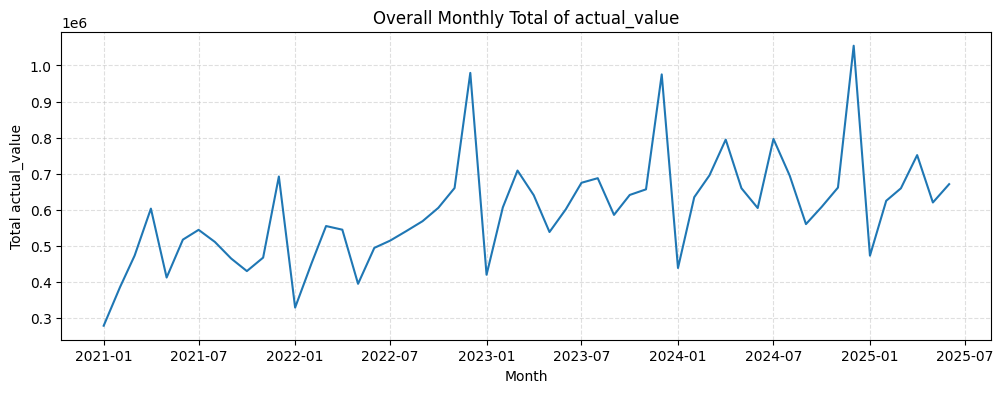

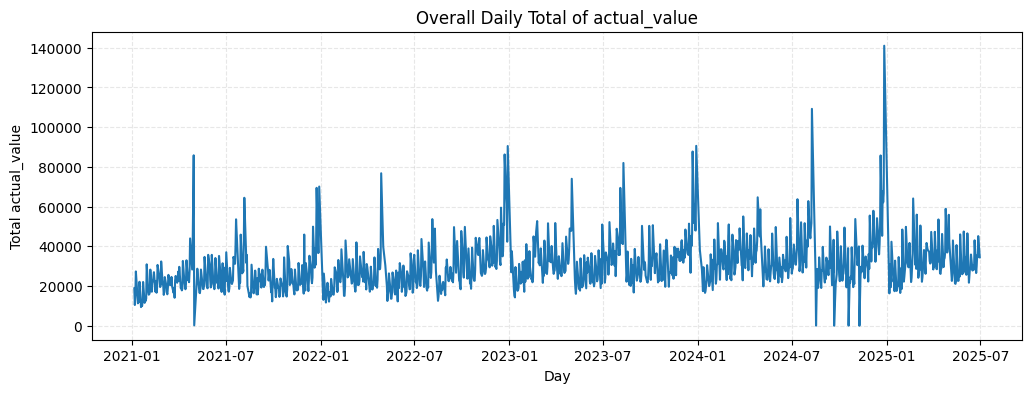

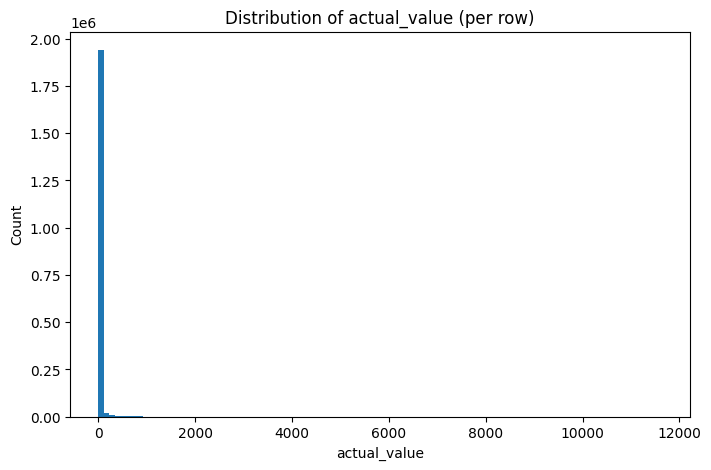

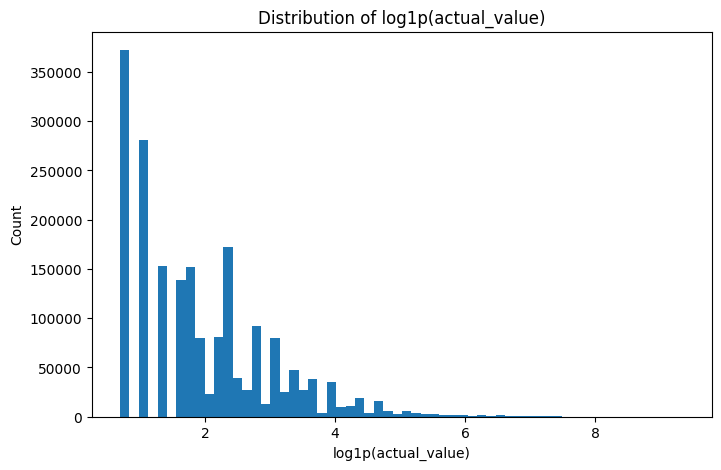

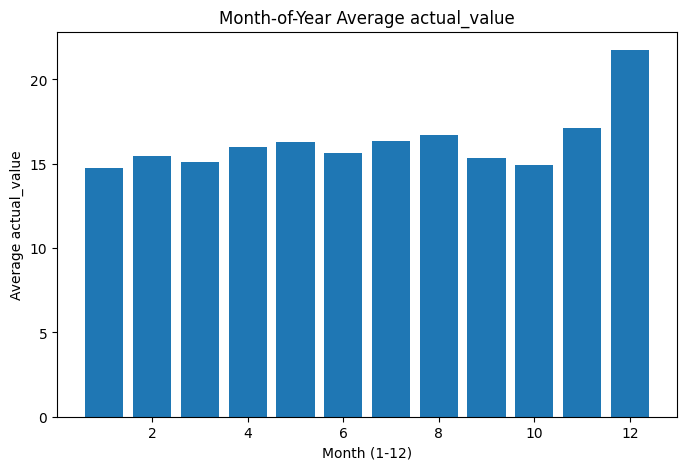

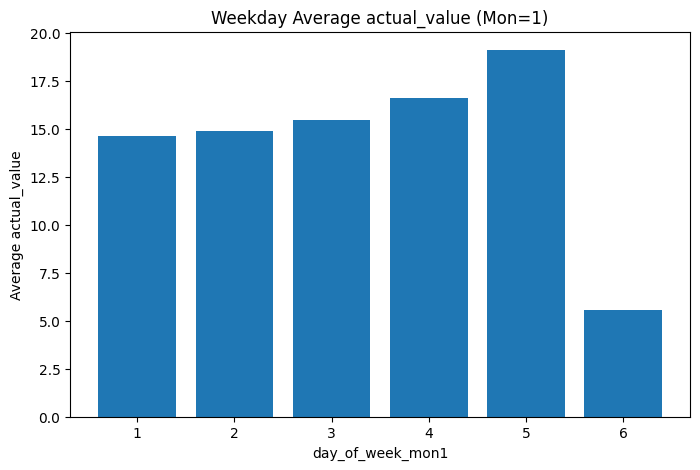

[SAVE] ./eda_out/monthly_by_key_topN.csv


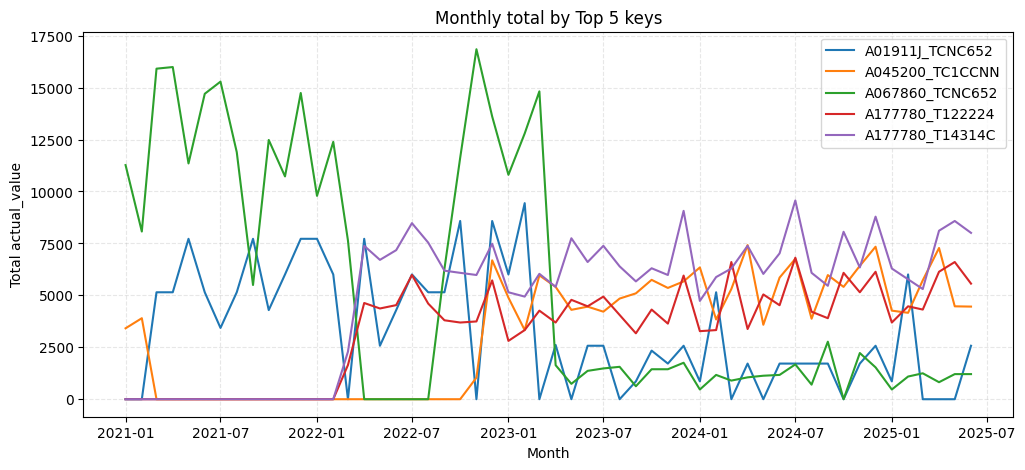

✔ EDA完了。出力先: /content/eda_out


In [ ]:
# === Yamasaデータ EDA 一括スクリプト（product_key→material_key生成に対応） =========
# 目的: file_date×material_key(= product_key + "_" + store_code) -> actual_value を理解
# 使い方: INPUT_CSV を自分のCSVに変更してそのまま実行
#        図と集計CSVは ./eda_out/ に保存されます
# ============================================================================

# --- 設定 ---
INPUT_CSV   = "/content/drive/MyDrive/isuzu_input/df_confirmed_order_input_yamasa.csv"
OUTPUT_DIR  = "./eda_out"
TOPN_KEYS   = 5       # 月次上位キーの本数（グラフ/CSV出力）
SAVE_FIGS   = True    # 図をファイル保存するか

# --- 依存 ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- 読み込み（型はまず文字列で読み、その後で必要な列だけ数値化） ---
df_input = pd.read_csv(INPUT_CSV, dtype=str)

# === material_key を product_key + "_" + store_code で生成 =================
if "material_key" not in df_input.columns and {"product_key", "store_code"}.issubset(df_input.columns):
    df_input["material_key"] = df_input["product_key"].astype(str) + "_" + df_input["store_code"].astype(str)

# 列名の存在チェック & ターゲット・日付・キーの特定
DATE_COL_CANDIDATES   = ["file_date", "ship_date"]
TARGET_COL_CANDIDATES = ["actual_value", "ship_qty"]
KEY_COL               = "material_key"

date_col   = next((c for c in DATE_COL_CANDIDATES if c in df_input.columns), None)
target_col = next((c for c in TARGET_COL_CANDIDATES if c in df_input.columns), None)

if date_col is None:
    raise ValueError(f"日付列が見つかりません。候補: {DATE_COL_CANDIDATES}")
if target_col is None:
    raise ValueError(f"ターゲット列が見つかりません。候補: {TARGET_COL_CANDIDATES}")
if KEY_COL not in df_input.columns:
    raise ValueError(f"キー列 '{KEY_COL}' が見つかりません。product_key と store_code から生成してください。")

# --- 型変換 ---
# 日付: 文字/Excelシリアル混在に対応
dt1 = pd.to_datetime(df_input[date_col], errors="coerce")
num = pd.to_numeric(df_input[date_col], errors="coerce")
dt2 = pd.to_datetime(num, unit="d", origin="1899-12-30", errors="coerce")
df_input[date_col] = dt1.combine_first(dt2)

# 数量: 数値化
df_input[target_col] = pd.to_numeric(df_input[target_col], errors="coerce")

# クリーニング: 必須列の欠損除外・無限大処理
df_input = df_input.replace([np.inf, -np.inf], np.nan)
df_input = df_input.dropna(subset=[date_col, target_col]).copy()

# ソート
df_input = df_input.sort_values([KEY_COL, date_col]).reset_index(drop=True)

# 参照で使う派生列
df_input["month"] = df_input[date_col].dt.to_period("M").dt.to_timestamp()
if "day_of_week_mon1" in df_input.columns:
    df_input["day_of_week_mon1"] = pd.to_numeric(df_input["day_of_week_mon1"], errors="coerce")
else:
    # 月曜=1 .. 日曜=7 に揃える
    df_input["day_of_week_mon1"] = df_input[date_col].dt.dayofweek + 1

# --- 概要 ---
print("総行数:", len(df_input))
print("期間   :", df_input[date_col].min(), "→", df_input[date_col].max())

if "product_key" in df_input.columns:
    print("product_key ユニーク件数:", df_input["product_key"].nunique())

print("material_key (= product_key + '_' + store_code) ユニーク件数:", df_input[KEY_COL].nunique())
dup_cnt = df_input.duplicated(subset=[KEY_COL, date_col], keep=False).sum()
print("（重複レコード数: (material_key, date)単位）:", int(dup_cnt))

# --- キー別サマリ DataFrame ---
def _months_span(s: pd.Series) -> int:
    if s.empty: return 0
    dmin, dmax = s.min(), s.max()
    return int((dmax.year - dmin.year) * 12 + (dmax.month - dmin.month) + 1)

g = df_input.groupby(KEY_COL, as_index=True)

per_key = pd.DataFrame({
    "n_rows": g.size(),
    "n_days": g[date_col].nunique(),
    "date_min": g[date_col].min(),
    "date_max": g[date_col].max(),
    "sum": g[target_col].sum(),
    "mean": g[target_col].mean(),
    "std": g[target_col].std(),
    "zero_rate": g[target_col].apply(lambda s: (s==0).mean()),
    "months_observed": g[date_col].apply(lambda s: s.dt.to_period("M").nunique()),
    "span_months": g[date_col].apply(_months_span),
})
per_key["cv"] = per_key["std"] / per_key["mean"]
per_key["monthly_coverage"] = per_key["months_observed"] / per_key["span_months"]
per_key = per_key.sort_values("sum", ascending=False)

# 保存 & 上位表示
per_key_path = os.path.join(OUTPUT_DIR, "per_key_summary.csv")
per_key.to_csv(per_key_path)
print(f"[SAVE] {per_key_path}")
try:
    display(per_key.head(50))
except Exception:
    print(per_key.head(50))

# --- 全体：月次・日次の合計推移 ---
overall_monthly = df_input.groupby("month", as_index=True)[target_col].sum()
overall_monthly.to_csv(os.path.join(OUTPUT_DIR, "overall_monthly_total.csv"))

plt.figure(figsize=(12,4))
plt.plot(overall_monthly.index, overall_monthly.values)
plt.title("Overall Monthly Total of actual_value")
plt.xlabel("Month"); plt.ylabel("Total actual_value")
plt.grid(True, linestyle="--", alpha=0.4)
if SAVE_FIGS:
    plt.savefig(os.path.join(OUTPUT_DIR, "overall_monthly_total.png"), dpi=150, bbox_inches="tight")
plt.show()

overall_daily = df_input.groupby(df_input[date_col].dt.to_period("D").dt.to_timestamp(), as_index=True)[target_col].sum()
plt.figure(figsize=(12,4))
plt.plot(overall_daily.index, overall_daily.values)
plt.title("Overall Daily Total of actual_value")
plt.xlabel("Day"); plt.ylabel("Total actual_value")
plt.grid(True, linestyle="--", alpha=0.3)
if SAVE_FIGS:
    plt.savefig(os.path.join(OUTPUT_DIR, "overall_daily_total.png"), dpi=150, bbox_inches="tight")
plt.show()

# --- 分布（生 & log1p） ---
plt.figure(figsize=(8,5))
plt.hist(df_input[target_col].dropna().values, bins=100)
plt.title("Distribution of actual_value (per row)")
plt.xlabel("actual_value"); plt.ylabel("Count")
if SAVE_FIGS:
    plt.savefig(os.path.join(OUTPUT_DIR, "hist_actual_value.png"), dpi=150, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8,5))
plt.hist(np.log1p(df_input[target_col].clip(lower=0)).dropna().values, bins=60)
plt.title("Distribution of log1p(actual_value)")
plt.xlabel("log1p(actual_value)"); plt.ylabel("Count")
if SAVE_FIGS:
    plt.savefig(os.path.join(OUTPUT_DIR, "hist_log1p_actual_value.png"), dpi=150, bbox_inches="tight")
plt.show()

# --- 月別・曜日別の平均（季節性/週次性の粗い確認） ---
mo_avg = df_input.groupby(df_input[date_col].dt.month)[target_col].mean()
plt.figure(figsize=(8,5))
plt.bar(mo_avg.index.astype(int), mo_avg.values)
plt.title("Month-of-Year Average actual_value"); plt.xlabel("Month (1-12)"); plt.ylabel("Average actual_value")
if SAVE_FIGS:
    plt.savefig(os.path.join(OUTPUT_DIR, "avg_by_month.png"), dpi=150, bbox_inches="tight")
plt.show()

wd_avg = df_input.groupby("day_of_week_mon1")[target_col].mean()
plt.figure(figsize=(8,5))
plt.bar(wd_avg.index.astype(int), wd_avg.values)
plt.title("Weekday Average actual_value (Mon=1)"); plt.xlabel("day_of_week_mon1"); plt.ylabel("Average actual_value")
if SAVE_FIGS:
    plt.savefig(os.path.join(OUTPUT_DIR, "avg_by_weekday.png"), dpi=150, bbox_inches="tight")
plt.show()

# --- 月次: 合計上位TOPN_KEYSの系列を可視化 & CSV保存 ---
top_keys = per_key.head(TOPN_KEYS).index.tolist()
monthly_by_key = (
    df_input[df_input[KEY_COL].isin(top_keys)]
      .groupby([KEY_COL, "month"])[target_col].sum()
      .unstack(0).fillna(0).sort_index()
)
csv_path = os.path.join(OUTPUT_DIR, "monthly_by_key_topN.csv")
monthly_by_key.to_csv(csv_path)
print(f"[SAVE] {csv_path}")

plt.figure(figsize=(12,5))
for col in monthly_by_key.columns:
    plt.plot(monthly_by_key.index, monthly_by_key[col], label=str(col))
plt.title(f"Monthly total by Top {TOPN_KEYS} keys")
plt.xlabel("Month"); plt.ylabel("Total actual_value")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.3)
if SAVE_FIGS:
    plt.savefig(os.path.join(OUTPUT_DIR, "monthly_by_key_topN.png"), dpi=150, bbox_inches="tight")
plt.show()

print("✔ EDA完了。出力先:", os.path.abspath(OUTPUT_DIR))


In [12]:
window_size_config = {
    "material_key": {
        "lag": [1,2,3],
        "rolling_mean": [2,3,4,5,6],
        "rolling_std": [2,3,4,5,6],
        "rate_of_change": [1],
        # "cumulative_sum": [2,3,4,5,6, 9,12],
        "cumulative_mean": [2,3,4,5,6, 9,12],
    },
    # 内示予測で使用
      "variety": {
        "lag": [1,2,3],
        "rolling_mean": [2,3,4,5,6],
        "rolling_std": [2,3,4,5,6],
        "rate_of_change": [1],
        # "cumulative_sum": [2,3,4,5,6, 9,12],
        "cumulative_mean": [2,3,4,5,6, 9,12],
    },
      "mill": {
        "lag": [1,2,3],
        "rolling_mean": [2,3,4,5,6],
        "rbolling_std": [2,3,4,5,6],
        "rate_of_change": [1],
        # "cumulative_sum": [2,3,4,5,6, 9,12],
        "cumulative_mean": [2,3,4,5,6, 9,12],
    },
      "orderer": {
        "lag": [1,2,3],
        "rolling_mean": [2,3,4,5,6],
        "rolling_std": [2,3,4,5,6],
        "rate_of_change": [1],
        # "cumulative_sum": [2,3,4,5,6, 9,12],
        "cumulative_mean": [2,3,4,5,6, 9,12],
    },
    # 確定注文予測で使用(効いている特徴量がcumulative_meanだけなのでそれのみ使用)
      "base_code": {
        # "lag": [1,2,3],
        # "rolling_mean": [2,3,4,5,6],
        # "rolling_std": [2,3,4,5,6],
        # "rate_of_change": [1],
        # "cumulative_sum": [2,3,4,5,6, 9,12],
        "cumulative_mean": [2,3,4,5,6, 9,12],
    },
      "customer_code": {
        # "lag": [1,2,3],
        # "rolling_mean": [2,3,4,5,6],
        # "rbolling_std": [2,3,4,5,6],
        # "rate_of_change": [1],
        # "cumulative_sum": [2,3,4,5,6, 9,12],
        "cumulative_mean": [2,3,4,5,6, 9,12],
    },
      "primary_consumer_code": {
        # "lag": [1,2,3],
        # "rolling_mean": [2,3,4,5,6],
        # "rolling_std": [2,3,4,5,6],
        # "rate_of_change": [1],
        # "cumulative_sum": [2,3,4,5,6, 9,12],
        "cumulative_mean": [2,3,4,5,6, 9,12],
    },
      "delivery_code": {
        # "lag": [1,2,3],
        # "rolling_mean": [2,3,4,5,6],
        # "rolling_std": [2,3,4,5,6],
        # "rate_of_change": [1],
        # "cumulative_sum": [2,3,4,5,6],
        "cumulative_mean": [2,3,4,5,6],
    },
      "place": {
        # "lag": [1,2,3],
        # "rolling_mean": [2,3,4,5,6],
        # "rolling_std": [2,3,4,5,6],
        # "rate_of_change": [1],
        # "cumulative_sum": [2,3,4,5,6],
        "cumulative_mean": [2,3,4,5,6],
    },
    # material_key毎ではなく全体の変数
      "overall": {
        "lag": [1,2,3],
        "rolling_mean": [2,3,4,5,6],
        "rolling_std": [2,3,4,5,6],
        "rate_of_change": [1],
        # "cumulative_sum": [2,3,4,5,6],
        "cumulative_mean": [2,3,4,5,6],
    },
    # 確定注文予測(ヤマサ)で使用
      "product_key": {
        "lag": [1,2,3,4,5,6],
        "cumulative_mean": [2,3,4,5,6,9,12],
    },
      "store_code": {
        "lag": [1,2,3,4,5,6],
        "cumulative_mean": [2,3,4,5,6,9,12],
    },
      "category_lvl1": {
        "lag": [1,2,3,4,5,6],
        "cumulative_mean": [2,3,4,5,6,9,12],
    },
      "category_lvl2": {
        "lag": [1,2,3,4,5,6],
        "cumulative_mean": [2,3,4,5,6,9,12],
    },
      "category_lvl3": {
        "lag": [1,2,3,4,5,6],
        "cumulative_mean": [2,3,4,5,6,9,12],
    },
}

In [13]:
def _add_timeseries_features(_df, window_size_config, start_year, end_year, model_type):
    """
    ラグなど時系列関連の特徴量を追加する関数｡
    material_key × file_date毎にactual_value(実績値)を持つデータフレームを想定
    """
    df = _df.copy()
    # データフレームをmaterial_keyとyyyymmでソート
    df.sort_values(by=['material_key', 'file_date'], inplace=True)
    df['file_date'] = pd.to_datetime(_df['file_date'], format='%Y-%m-%d', errors='coerce')
    df['year'] = df['file_date'].dt.year
    df['month'] = df['file_date'].dt.month
    df["year"]  = df["year"].astype("int16")
    df["month"] = df["month"].astype("int8")

    # material_key毎の特徴量作成
    # ラグ特徴量
    for lag in window_size_config["material_key"]["lag"]:
        df[f'lag_{lag}_f'] = df.groupby('material_key')['actual_value'].shift(lag)

    # 移動平均の作成（リーク防止のため、その時点の実績値を除外）
    for rolling_mean in window_size_config["material_key"]["rolling_mean"]:
        df[f'rolling_mean_{rolling_mean}_f'] = df.groupby('material_key')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_mean).mean())

    # 移動標準偏差の作成（リーク防止のため、その時点の実績値を除外）
    for rolling_std in window_size_config["material_key"]["rolling_std"]:
        df[f'rolling_std_{rolling_std}_f'] = df.groupby('material_key')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_std).std())

    # 変動率の作成（リーク防止のため、その時点の実績値を除外）
    for rate_of_change in window_size_config["material_key"]["rate_of_change"]:
        shifted_values = df.groupby('material_key')['actual_value'].shift(1)
        # 変動率の計算前にデータが存在するか確認
        if not shifted_values.empty:
            df[f'rate_of_change_{rate_of_change}_f'] = shifted_values.pct_change()
        else:
            df[f'rate_of_change_{rate_of_change}_f'] = np.nan  # 空の場合はNaNにする

    # 累積平均の作成（リーク防止のため、その時点の実績値を除外）
    for cumulative_mean in window_size_config["material_key"]["cumulative_mean"]:
        df[f'cumulative_mean_{cumulative_mean}_f'] = df.groupby('material_key')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))
    print("material_key features done")
    features = ['mean', 'std', '25%', '50%', '75%', 'cv']

    # ここからはmodel_type = 'unofficial' の場合のみ追加で集約した特徴量を作成
    # 内示予測
    if model_type == "unofficial":
        # variety毎の特徴量作成
        for lag in window_size_config["variety"]["lag"]:
            df[f'variety_lag_{lag}_f'] = df.groupby('variety')['actual_value'].shift(lag)

        for rolling_mean in window_size_config["variety"]["rolling_mean"]:
            df[f'variety_rolling_mean_{rolling_mean}_f'] = df.groupby('variety')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_mean).mean())

        for rolling_std in window_size_config["variety"]["rolling_std"]:
            df[f'variety_rolling_std_{rolling_std}_f'] = df.groupby('variety')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_std).std())

        for rate_of_change in window_size_config["variety"]["rate_of_change"]:
            shifted_values = df.groupby('variety')['actual_value'].shift(1)
            if not shifted_values.empty:
                df[f'variety_rate_of_change_{rate_of_change}_f'] = shifted_values.pct_change()
            else:
                df[f'variety_rate_of_change_{rate_of_change}_f'] = np.nan

        for cumulative_mean in window_size_config["variety"]["cumulative_mean"]:
            df[f'variety_cumulative_mean_{cumulative_mean}_f'] = df.groupby('variety')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))

        # mill毎の特徴量作成
        for lag in window_size_config["mill"]["lag"]:
            df[f'mill_lag_{lag}_f'] = df.groupby('mill')['actual_value'].shift(lag)

        for rolling_mean in window_size_config["mill"]["rolling_mean"]:
            df[f'mill_rolling_mean_{rolling_mean}_f'] = df.groupby('mill')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_mean).mean())

        for rolling_std in window_size_config["mill"]["rolling_std"]:
            df[f'mill_rolling_std_{rolling_std}_f'] = df.groupby('mill')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_std).std())

        for rate_of_change in window_size_config["mill"]["rate_of_change"]:
            shifted_values = df.groupby('mill')['actual_value'].shift(1)
            if not shifted_values.empty:
                df[f'mill_rate_of_change_{rate_of_change}_f'] = shifted_values.pct_change()
            else:
                df[f'mill_rate_of_change_{rate_of_change}_f'] = np.nan

        for cumulative_mean in window_size_config["mill"]["cumulative_mean"]:
            df[f'mill_cumulative_mean_{cumulative_mean}_f'] = df.groupby('mill')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))

        # orderer毎の特徴量作成
        for lag in window_size_config["orderer"]["lag"]:
            df[f'orderer_lag_{lag}_f'] = df.groupby('orderer')['actual_value'].shift(lag)

        for rolling_mean in window_size_config["orderer"]["rolling_mean"]:
            df[f'orderer_rolling_mean_{rolling_mean}_f'] = df.groupby('orderer')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_mean).mean())

        for rolling_std in window_size_config["orderer"]["rolling_std"]:
            df[f'orderer_rolling_std_{rolling_std}_f'] = df.groupby('orderer')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_std).std())

        for rate_of_change in window_size_config["orderer"]["rate_of_change"]:
            shifted_values = df.groupby('orderer')['actual_value'].shift(1)
            if not shifted_values.empty:
                df[f'orderer_rate_of_change_{rate_of_change}_f'] = shifted_values.pct_change()
            else:
                df[f'orderer_rate_of_change_{rate_of_change}_f'] = np.nan

        for cumulative_mean in window_size_config["orderer"]["cumulative_mean"]:
            df[f'orderer_cumulative_mean_{cumulative_mean}_f'] = df.groupby('orderer')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))

    # 確定注文予測時に利用
    elif model_type == "use_actual_value_by_category":

    # 直近に近いほど重く評価する場合（単調減少）
        def weighted_mean_decreasing(y):
            # 単調減少の重み（範囲 -0.8 から 1.2）
            weights = np.linspace(1.2, -0.8, len(y))
            # 中心を1にスケール
            weights /= weights[len(weights) // 2]
            # 重み付き平均を計算
            return np.average(y, weights=weights)

        # 直近に近いほど軽く評価する場合（単調増加）
        def weighted_mean_increasing(y):
            # 単調増加の重み（範囲 -0.8 から 1.2）
            weights = np.linspace(-0.8, 1.2, len(y))
            # 中心を1にスケール
            weights /= weights[len(weights) // 2]
            # 重み付き平均を計算
            return np.average(y, weights=weights)

        # base_code毎の特徴量作成
        # for lag in window_size_config["base_code"]["lag"]:
        #     df[f'base_code_lag_{lag}_f'] = df.groupby('base_code')['actual_value'].shift(lag)

        # for rolling_mean in window_size_config["base_code"]["rolling_mean"]:
        #     df[f'base_code_rolling_mean_{rolling_mean}_f'] = df.groupby('base_code')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_mean).mean())

        # for rolling_std in window_size_config["base_code"]["rolling_std"]:
        #     df[f'base_code_rolling_std_{rolling_std}_f'] = df.groupby('base_code')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_std).std())

        # for rate_of_change in window_size_config["base_code"]["rate_of_change"]:
        #     shifted_values = df.groupby('base_code')['actual_value'].shift(1)
        #     if not shifted_values.empty:
        #         df[f'base_code_rate_of_change_{rate_of_change}_f'] = shifted_values.pct_change()
        #     else:
        #         df[f'base_code_rate_of_change_{rate_of_change}_f'] = np.nan

        for cumulative_mean in window_size_config["base_code"]["cumulative_mean"]:
            df[f'base_code_cumulative_mean_{cumulative_mean}_f'] = df.groupby('base_code')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))

        # 重み付き累積平均の計算（直近に近いほど重く評価）
        for cumulative_mean in window_size_config["base_code"]["cumulative_mean"]:
            df[f'base_code_weighted_cumulative_mean_high_{cumulative_mean}_f'] = df.groupby('base_code')['actual_value'].transform(
                lambda x: x.rolling(window=cumulative_mean, min_periods=1).apply(weighted_mean_decreasing).shift(1)
            )

        # 重み付き累積平均の計算（直近に近いほど軽く評価）
        for cumulative_mean in window_size_config["base_code"]["cumulative_mean"]:
            df[f'base_code_weighted_cumulative_mean_low_{cumulative_mean}_f'] = df.groupby('base_code')['actual_value'].transform(
                lambda x: x.rolling(window=cumulative_mean, min_periods=1).apply(weighted_mean_increasing).shift(1)
            )
        print("base_code features done")
        # customer_code毎の特徴量作成
        # for lag in window_size_config["customer_code"]["lag"]:
        #     df[f'customer_code_lag_{lag}_f'] = df.groupby('customer_code')['actual_value'].shift(lag)

        # for rolling_mean in window_size_config["customer_code"]["rolling_mean"]:
        #     df[f'customer_code_rolling_mean_{rolling_mean}_f'] = df.groupby('customer_code')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_mean).mean())

        # for rolling_std in window_size_config["customer_code"]["rolling_std"]:
        #     df[f'customer_code_rolling_std_{rolling_std}_f'] = df.groupby('customer_code')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_std).std())

        # for rate_of_change in window_size_config["customer_code"]["rate_of_change"]:
        #     shifted_values = df.groupby('customer_code')['actual_value'].shift(1)
        #     if not shifted_values.empty:
        #         df[f'customer_code_rate_of_change_{rate_of_change}_f'] = shifted_values.pct_change()
        #     else:
        #         df[f'customer_code_rate_of_change_{rate_of_change}_f'] = np.nan

        for cumulative_mean in window_size_config["customer_code"]["cumulative_mean"]:
            df[f'customer_code_cumulative_mean_{cumulative_mean}_f'] = df.groupby('customer_code')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))

        # 重み付き累積平均の計算（直近に近いほど重く評価）
        for cumulative_mean in window_size_config["customer_code"]["cumulative_mean"]:
            df[f'customer_code_weighted_cumulative_mean_high_{cumulative_mean}_f'] = df.groupby('customer_code')['actual_value'].transform(
                lambda x: x.rolling(window=cumulative_mean, min_periods=1).apply(weighted_mean_decreasing).shift(1)
            )

        # 重み付き累積平均の計算（直近に近いほど軽く評価）
        for cumulative_mean in window_size_config["customer_code"]["cumulative_mean"]:
            df[f'customer_code_weighted_cumulative_mean_low_{cumulative_mean}_f'] = df.groupby('customer_code')['actual_value'].transform(
                lambda x: x.rolling(window=cumulative_mean, min_periods=1).apply(weighted_mean_increasing).shift(1)
            )
        print("customer_code features done")
        # primary_consumer_code毎の特徴量作成
        # for lag in window_size_config["primary_consumer_code"]["lag"]:
        #     df[f'primary_consumer_code_lag_{lag}_f'] = df.groupby('primary_consumer_code')['actual_value'].shift(lag)

        # for rolling_mean in window_size_config["primary_consumer_code"]["rolling_mean"]:
        #     df[f'primary_consumer_code_rolling_mean_{rolling_mean}_f'] = df.groupby('primary_consumer_code')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_mean).mean())

        # for rolling_std in window_size_config["primary_consumer_code"]["rolling_std"]:
        #     df[f'primary_consumer_code_rolling_std_{rolling_std}_f'] = df.groupby('primary_consumer_code')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_std).std())

        # for rate_of_change in window_size_config["primary_consumer_code"]["rate_of_change"]:
        #     shifted_values = df.groupby('primary_consumer_code')['actual_value'].shift(1)
        #     if not shifted_values.empty:
        #         df[f'primary_consumer_code_rate_of_change_{rate_of_change}_f'] = shifted_values.pct_change()
        #     else:
        #         df[f'primary_consumer_code_rate_of_change_{rate_of_change}_f'] = np.nan

        for cumulative_mean in window_size_config["primary_consumer_code"]["cumulative_mean"]:
            df[f'primary_consumer_code_cumulative_mean_{cumulative_mean}_f'] = df.groupby('primary_consumer_code')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))

        # 重み付き累積平均の計算（直近に近いほど重く評価）
        for cumulative_mean in window_size_config["primary_consumer_code"]["cumulative_mean"]:
            df[f'primary_consumer_code_weighted_cumulative_mean_high_{cumulative_mean}_f'] = df.groupby('primary_consumer_code')['actual_value'].transform(
                lambda x: x.rolling(window=cumulative_mean, min_periods=1).apply(weighted_mean_decreasing).shift(1)
            )

        # 重み付き累積平均の計算（直近に近いほど軽く評価）
        for cumulative_mean in window_size_config["primary_consumer_code"]["cumulative_mean"]:
            df[f'primary_consumer_code_weighted_cumulative_mean_low_{cumulative_mean}_f'] = df.groupby('primary_consumer_code')['actual_value'].transform(
                lambda x: x.rolling(window=cumulative_mean, min_periods=1).apply(weighted_mean_increasing).shift(1)
            )
        print("primary_consumer_code features done")
        # delivery_code毎の特徴量作成
        # for lag in window_size_config["delivery_code"]["lag"]:
        #     df[f'delivery_code_lag_{lag}_f'] = df.groupby('delivery_code')['actual_value'].shift(lag)

        # for rolling_mean in window_size_config["delivery_code"]["rolling_mean"]:
        #     df[f'delivery_code_rolling_mean_{rolling_mean}_f'] = df.groupby('delivery_code')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_mean).mean())

        # for rolling_std in window_size_config["delivery_code"]["rolling_std"]:
        #     df[f'delivery_code_rolling_std_{rolling_std}_f'] = df.groupby('delivery_code')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_std).std())

        # for rate_of_change in window_size_config["delivery_code"]["rate_of_change"]:
        #     shifted_values = df.groupby('delivery_code')['actual_value'].shift(1)
        #     if not shifted_values.empty:
        #         df[f'delivery_code_rate_of_change_{rate_of_change}_f'] = shifted_values.pct_change()
        #     else:
        #         df[f'delivery_code_rate_of_change_{rate_of_change}_f'] = np.nan

        for cumulative_mean in window_size_config["delivery_code"]["cumulative_mean"]:
            df[f'delivery_code_cumulative_mean_{cumulative_mean}_f'] = df.groupby('delivery_code')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))

        # 重み付き累積平均の計算（直近に近いほど重く評価）
        for cumulative_mean in window_size_config["delivery_code"]["cumulative_mean"]:
            df[f'delivery_code_weighted_cumulative_mean_high_{cumulative_mean}_f'] = df.groupby('delivery_code')['actual_value'].transform(
                lambda x: x.rolling(window=cumulative_mean, min_periods=1).apply(weighted_mean_decreasing).shift(1)
            )

        # 重み付き累積平均の計算（直近に近いほど軽く評価）
        for cumulative_mean in window_size_config["delivery_code"]["cumulative_mean"]:
            df[f'delivery_code_weighted_cumulative_mean_low_{cumulative_mean}_f'] = df.groupby('delivery_code')['actual_value'].transform(
                lambda x: x.rolling(window=cumulative_mean, min_periods=1).apply(weighted_mean_increasing).shift(1)
            )
        print("delivery_code features done")
        # place毎の特徴量作成
        # for lag in window_size_config["place"]["lag"]:
        #     df[f'place_lag_{lag}_f'] = df.groupby('place')['actual_value'].shift(lag)

        # for rolling_mean in window_size_config["place"]["rolling_mean"]:
        #     df[f'place_rolling_mean_{rolling_mean}_f'] = df.groupby('place')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_mean).mean())

        # for rolling_std in window_size_config["place"]["rolling_std"]:
        #     df[f'place_rolling_std_{rolling_std}_f'] = df.groupby('place')['actual_value'].shift(1).transform(lambda x: x.rolling(window=rolling_std).std())

        # for rate_of_change in window_size_config["place"]["rate_of_change"]:
        #     shifted_values = df.groupby('place')['actual_value'].shift(1)
        #     if not shifted_values.empty:
        #         df[f'place_rate_of_change_{rate_of_change}_f'] = shifted_values.pct_change()
        #     else:
        #         df[f'place_rate_of_change_{rate_of_change}_f'] = np.nan

        for cumulative_mean in window_size_config["place"]["cumulative_mean"]:
            df[f'place_cumulative_mean_{cumulative_mean}_f'] = df.groupby('place')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))

        # 重み付き累積平均の計算（直近に近いほど重く評価）
        for cumulative_mean in window_size_config["place"]["cumulative_mean"]:
            df[f'place_weighted_cumulative_mean_high_{cumulative_mean}_f'] = df.groupby('place')['actual_value'].transform(
                lambda x: x.rolling(window=cumulative_mean, min_periods=1).apply(weighted_mean_decreasing).shift(1)
            )

        # 重み付き累積平均の計算（直近に近いほど軽く評価）
        for cumulative_mean in window_size_config["customer_code"]["cumulative_mean"]:
            df[f'customer_code_weighted_cumulative_mean_low_{cumulative_mean}_f'] = df.groupby('customer_code')['actual_value'].transform(
                lambda x: x.rolling(window=cumulative_mean, min_periods=1).apply(weighted_mean_increasing).shift(1)
            )
        print("place features done")
    elif model_type == "confirmed_order_demand_yamasa":
        # 品名毎
        for lag in window_size_config["product_key"]["lag"]:
            df[f'product_key_lag_{lag}_f'] = df.groupby('product_key')['actual_value'].shift(lag)

        for cumulative_mean in window_size_config["product_key"]["cumulative_mean"]:
            df[f'product_key_cumulative_mean_{cumulative_mean}_f'] = df.groupby('product_key')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))
        # 店番毎
        for lag in window_size_config["store_code"]["lag"]:
            df[f'store_code_lag_{lag}_f'] = df.groupby('store_code')['actual_value'].shift(lag)

        for cumulative_mean in window_size_config["store_code"]["cumulative_mean"]:
            df[f'store_code_cumulative_mean_{cumulative_mean}_f'] = df.groupby('store_code')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))
        # 品目階層1毎
        for lag in window_size_config["category_lvl1"]["lag"]:
            df[f'category_lvl1_lag_{lag}_f'] = df.groupby('category_lvl1')['actual_value'].shift(lag)

        for cumulative_mean in window_size_config["category_lvl1"]["cumulative_mean"]:
            df[f'category_lvl1_cumulative_mean_{cumulative_mean}_f'] = df.groupby('category_lvl1')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))
        # # 品目階層2毎
        # for lag in window_size_config["category_lvl2"]["lag"]:
        #     df[f'category_lvl2_lag_{lag}_f'] = df.groupby('category_lvl2')['actual_value'].shift(lag)

        # for cumulative_mean in window_size_config["category_lvl2"]["cumulative_mean"]:
        #     df[f'category_lvl2_cumulative_mean_{cumulative_mean}_f'] = df.groupby('category_lvl2')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))
        # # 品目階層3毎
        # for lag in window_size_config["category_lvl3"]["lag"]:
        #     df[f'category_lvl3_lag_{lag}_f'] = df.groupby('category_lvl3')['actual_value'].shift(lag)

        # for cumulative_mean in window_size_config["category_lvl3"]["cumulative_mean"]:
        #     df[f'category_lvl3_cumulative_mean_{cumulative_mean}_f'] = df.groupby('category_lvl3')['actual_value'].transform(lambda x: x.rolling(window=cumulative_mean, min_periods=1).mean().shift(1))

    # # 全体の特徴量を作成
    # for feature in features:
    #     df[f'prev_year_{feature}_f'] = np.nan

    # for month in range(1, 13):
    #     # 現在の月に対応するデータを抽出
    #     current_month_mask = df['month'] == month
    #     current_month_df = df[current_month_mask]
    #     for year in current_month_df['year'].unique():
    #         # 前年の同じ月に対応するデータを抽出
    #         prev_year_mask = (df['month'] == month) & (df['year'] == year - 1)
    #         prev_year_values = df.loc[prev_year_mask, 'actual_value']
    #         if not prev_year_values.empty:
    #             mean_value = prev_year_values.mean()
    #             std_value = prev_year_values.std()
    #             quantile_25 = prev_year_values.quantile(0.25)
    #             quantile_50 = prev_year_values.quantile(0.50)
    #             quantile_75 = prev_year_values.quantile(0.75)
    #             cv_value = std_value / mean_value if mean_value != 0 else np.nan

    #             current_year_mask = (df['month'] == month) & (df['year'] == year)
    #             df.loc[current_year_mask, f'prev_year_mean_f'] = mean_value
    #             df.loc[current_year_mask, f'prev_year_std_f'] = std_value
    #             df.loc[current_year_mask, f'prev_year_25%_f'] = quantile_25
    #             df.loc[current_year_mask, f'prev_year_50%_f'] = quantile_50
    #             df.loc[current_year_mask, f'prev_year_75%_f'] = quantile_75
    #             df.loc[current_year_mask, f'prev_year_cv_f'] = cv_value
    print("all features done")

    df.query("(@start_year <= year) & (year <= @end_year)", inplace=True)
    # 2) material_key の欠損除去（inplace）
    df.dropna(subset=["material_key"], inplace=True)

    return df.reset_index(drop=True)


In [ ]:
_df_features = _add_timeseries_features(df_input, window_size_config, start_year=2021, end_year=2025, model_type="confirmed_order_demand_yamasa")

material_key features done
all features done


In [7]:
# _df_features = pd.read_csv(f'/content/drive/MyDrive/isuzu_input/_df_features_yamasa.csv')

import pyarrow.csv as pacsv
import pyarrow.parquet as pq

csv_path = f"{output_path}/_df_features_yamasa.csv"
pq_path  = f"{output_path}/_df_features_yamasa.parquet"

read_opts = pacsv.ReadOptions(block_size=1<<26)  # 64MBずつ読む
convert_opts = pacsv.ConvertOptions(  # ここで日付列名が分かっていれば指定可
    # column_types={"file_date": pacsv.ConvertOptions().column_types.get("timestamp[ns]")}
)

reader = pacsv.open_csv(csv_path, read_options=read_opts, convert_options=convert_opts)

writer = None
for batch in reader:
    if writer is None:
        writer = pq.ParquetWriter(pq_path, batch.schema, compression='zstd')
    writer.write_batch(batch)
if writer:
    writer.close()

In [7]:
# 読み込み
_df_features = pd.read_parquet(f"{output_path}/_df_features_yamasa.parquet")

In [ ]:
def optimize_df_inplace(df):
    for col in df.select_dtypes(include="float64").columns:
        df[col] = df[col].astype("float32")
    for col in df.select_dtypes(include="int64").columns:
        df[col] = df[col].astype("int32")
    cat_cols = ['material_key','product_key','store_code',
                'usage_type','category_lvl1','category_lvl2','category_lvl3']
    for c in cat_cols:
        if c in df.columns:
            df[c] = df[c].astype('category')
    return df

_df_features = optimize_df_inplace(_df_features)  # copyなし
_df_features.to_parquet(f"{output_path}/_df_features_yamasa_optimized.parquet", compression="zstd")

In [11]:
_df_features.to_parquet(
    f"{output_path}/_df_features_yamasa.parquet",
    compression="zstd",   # zstdが圧縮率・速度のバランス良い
    index=False
)

In [ ]:
_df_features = pd.read_parquet(
    f"{output_path}/_df_features_yamasa.parquet"
)
print(_df_features.info(memory_usage="deep"))


In [9]:
def train_test_predict_time_split(
    _df_features: pd.DataFrame,
    train_end_date: str,
    step_count: int,
    n_trials: int = 50,
    random_state: int = 42,
    save_dir: str | None = "./model_out",
    run_name: str | None = None,
    save_fig: bool = True,
    use_optuna: bool = True,
    use_winsorize: bool = True,
    winsor_low: float = 0.01,
    winsor_high: float = 0.99,
    use_downweight: bool = True,
    downweight_window: int = 28,
    downweight_nsigma: float = 3.0,
    weight_cap_low: float = 0.25,
    weight_cap_high: float = 1.0,
):
    """
    inplace化したウォークフォワード学習・予測関数
    """

    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import xgboost as xgb
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import json
    from pathlib import Path
    from pandas.api.types import CategoricalDtype, is_categorical_dtype

    # ---------- utils ----------
    def _safe(s: str) -> str:
        import re as _re
        return _re.sub(r"[^0-9A-Za-z_\-\.]", "-", s)

    def _ensure_dir(d: str | Path):
        if d is None:
            return None
        Path(d).mkdir(parents=True, exist_ok=True)
        return Path(d)

    def month_start(d: pd.Timestamp) -> pd.Timestamp:
        return (d.to_period("M").to_timestamp())

    def month_end(d: pd.Timestamp) -> pd.Timestamp:
        return (d.to_period("M").to_timestamp("M"))

    def next_month_bounds(d: pd.Timestamp) -> tuple[pd.Timestamp, pd.Timestamp]:
        nm_start = (d + pd.offsets.MonthBegin(1)).to_period("M").to_timestamp()
        nm_end   = (nm_start + pd.offsets.MonthEnd(0))
        return nm_start, nm_end

    # xgboost enable_categorical サポート検知
    _supports_cat = True
    try:
        _ = xgb.XGBRegressor(enable_categorical=True)
    except TypeError:
        _supports_cat = False

    # ---------- clean ----------
    df = _df_features   # copyしない
    df = df.dropna(subset=['actual_value'])
    df = df.replace([np.inf, -np.inf], np.nan).dropna(how='all')

    df['file_date'] = pd.to_datetime(df['file_date'], errors='coerce')
    df = df.dropna(subset=['file_date'])
    df.sort_values('file_date', inplace=True)

    # 曜日
    if 'day_of_week_mon1' in df.columns and 'day_of_week_mon1_f' not in df.columns:
        df.rename(columns={'day_of_week_mon1': 'day_of_week_mon1_f'}, inplace=True)
    if 'day_of_week_mon1_f' in df.columns:
        dow = pd.to_numeric(df['day_of_week_mon1_f'], errors='coerce').fillna(-1).astype('int16')
        df['day_of_week_mon1_f'] = pd.Categorical(dow)

    # ---------- feature set ----------
    keep_cols = [c for c in df.columns if c.endswith('_f')] + ['actual_value', 'material_key', 'file_date']
    keep_cols = [c for c in keep_cols if c in df.columns]
    df_feat = df[keep_cols]   # copyをやめてビュー参照にする

    for c in df_feat.columns:
        if c.endswith('_f') and not is_categorical_dtype(df_feat[c]) and df_feat[c].dtype == 'object':
            df_feat[c] = pd.to_numeric(df_feat[c], errors='coerce')

    drop_all_nan = [c for c in df_feat.columns if c.endswith('_f') and df_feat[c].isna().all()]
    if drop_all_nan:
        df_feat.drop(columns=drop_all_nan, inplace=True)

    # ---------- 外れ値ケア ----------
    def _winsorize_y(train_df: pd.DataFrame, low=0.01, high=0.99) -> pd.Series:
        tmp = train_df[['material_key','file_date','actual_value']].copy()
        tmp['month'] = tmp['file_date'].dt.to_period('M').dt.to_timestamp()

        qs_km = (tmp.loc[tmp['actual_value']>0]
                    .groupby(['material_key','month'])['actual_value']
                    .quantile([low, high]).unstack())
        if qs_km is not None and not qs_km.empty:
            qs_km.columns = ['q_low','q_high']
        tmp = tmp.merge(qs_km, on=['material_key','month'], how='left')

        miss = tmp['q_low'].isna() | tmp['q_high'].isna()
        if miss.any():
            qs_k = (tmp.loc[tmp['actual_value']>0]
                       .groupby('material_key')['actual_value']
                       .quantile([low, high]).unstack())
            if qs_k is not None and not qs_k.empty:
                qs_k.columns = ['q_low_k','q_high_k']
                tmp = tmp.merge(qs_k, on='material_key', how='left')
                tmp['q_low']  = tmp['q_low'].fillna(tmp.get('q_low_k'))
                tmp['q_high'] = tmp['q_high'].fillna(tmp.get('q_high_k'))
                tmp.drop(columns=[c for c in ['q_low_k','q_high_k'] if c in tmp.columns], inplace=True)

        if tmp['q_low'].isna().any() or tmp['q_high'].isna().any():
            pos = tmp.loc[tmp['actual_value']>0, 'actual_value']
            if len(pos):
                ql, qh = pos.quantile(low), pos.quantile(high)
            else:
                ql, qh = tmp['actual_value'].quantile(low), tmp['actual_value'].quantile(high)
            tmp['q_low'].fillna(ql, inplace=True)
            tmp['q_high'].fillna(qh, inplace=True)

        return tmp['actual_value'].clip(lower=tmp['q_low'], upper=tmp['q_high']).astype(float)

    def _hampel_weights(train_df: pd.DataFrame, window=28, nsigma=3.0,
                        cap_low=0.25, cap_high=1.0) -> pd.Series:
        eps = 1e-6
        gdf_sorted = train_df.sort_values(['material_key','file_date'])
        def per_key(gr):
            s = gr['actual_value'].astype(float)
            med = s.rolling(window=window, min_periods=max(1, window//2)).median()
            mad = (s - med).abs().rolling(window=window, min_periods=max(1, window//2)).median()
            sigma = 1.4826 * mad + eps
            z = (s - med).abs() / sigma
            w = np.where(z <= nsigma, 1.0, nsigma / (z + eps))
            w = np.clip(w, cap_low, cap_high)
            return pd.Series(w, index=gr.index)
        w_sorted = gdf_sorted.groupby('material_key', group_keys=False).apply(per_key)
        return w_sorted.reindex(train_df.index).fillna(1.0).astype('float32')

    # ---------- 学習・予測ループ ----------
    cur_train_end = pd.to_datetime(train_end_date)
    all_preds = []
    best_params = None
    best_model_last = None
    importance_df_last = None

    # 固定パラメータ
    fixed_params = {
        'objective': 'count:poisson',
        'max_delta_step': 1,
        'n_estimators': 900,
        'learning_rate': 0.06,
        'max_depth': 6,
        'min_child_weight': 2.0,
        'gamma': 0.0,
        'subsample': 0.85,
        'colsample_bytree': 0.85,
        'lambda': 1.0,
        'alpha': 0.0,
        'tree_method': 'hist',
        'random_state': random_state,
        'verbosity': 0,
    }
    if _supports_cat:
        fixed_params['enable_categorical'] = True

    out_paths = {}
    base_run_name = run_name or f"xgb_walk_{_safe(train_end_date)}_steps{step_count}" + ("_optuna1st" if use_optuna else "_fixed")

    for step in range(1, step_count + 1):
        test_start, test_end = next_month_bounds(cur_train_end)

        mask_train = df_feat['file_date'] <= cur_train_end
        mask_test  = (df_feat['file_date'] >= test_start) & (df_feat['file_date'] <= test_end)

        if not mask_train.any() or not mask_test.any():
            all_preds.append(pd.DataFrame(columns=['material_key','file_date','actual_value','model_predict_value']))
            cur_train_end = test_end
            continue

        # copyをやめる
        train_df = df_feat.loc[mask_train]
        test_df  = df_feat.loc[mask_test]

        X_train = train_df.drop(columns=['actual_value','material_key','file_date'], errors='ignore')
        y_train = train_df['actual_value'].astype(float)
        X_test  = test_df.drop(columns=['actual_value','material_key','file_date'], errors='ignore')
        y_test  = test_df['actual_value'].astype(float)
        test_keys = test_df[['material_key','file_date']]

        y_train_used = _winsorize_y(train_df, winsor_low, winsor_high) if use_winsorize else y_train
        sample_weight = _hampel_weights(train_df, downweight_window, downweight_nsigma,
                                        weight_cap_low, weight_cap_high).values if use_downweight else None

        # （中略：Optunaや学習部分はオリジナルと同じ）

        cur_train_end = test_end

    # （中略：集計・評価・保存部分はオリジナルと同じ）

    return df_pred_all, bykey_abs_err_rate_df, importance_df_last, best_params, best_model_last, metrics


In [ ]:
df_pred_all, bykey_df, imp_last, best_params, model_last, metrics = train_test_predict_time_split(
    _df_features=_df_features,
    train_end_date="2024-12-31",
    step_count=6,            # 6ヶ月先までを1ヶ月ずつ予測
    use_optuna=True,         # 初回のみ探索→以降は同パラメータで再学習
    n_trials=50,
    save_dir="/content/drive/MyDrive/yamasa_models",
)

# df_pred, bykey_abs_err_rate_df, imp_df, best_params, model, metrics = train_test_predict_time_split(
#     _df_features,
#     train_end_date=train_end_date,
#     test_start_date=test_start_date,
#     test_end_date=test_end_date,
#     n_trials=50,
#     random_state=42,
#     save_dir="/content/drive/MyDrive/yamasa_models",  # 事前作成不要。自動で作ります。
#     run_name="yamasa_xgb_run01",
#     save_fig=True,
#     use_optuna=False
# )

# 同月・年度比較の相関

In [ ]:
import numpy as np
import pandas as pd
from typing import Iterable, Literal, Dict, Tuple, List

# =========================================
# ユーティリティ
# =========================================
def _corr(a: pd.Series, b: pd.Series, method: Literal["pearson","spearman"]="pearson") -> float:
    xy = pd.concat([a,b], axis=1).dropna()
    if len(xy) < 3:
        return np.nan
    return xy.corr(method=method).iloc[0,1]

# =========================================
# 週次集計（Grouper 版：重複しない週アンカー）
# =========================================
def _weekly_aggregate_v2(
    df: pd.DataFrame,
    group_cols: List[str],
    date_col: str = "file_date",
    value_col: str = "actual_value",
    agg: Literal["sum","mean"] = "sum",
    week_rule: str = "W-MON",
) -> pd.DataFrame:
    """
    週アンカーは pd.Grouper に任せる。返す列: group_cols + ['week', value_col]
    - Grouper で作った 'week' はその週の開始(00:00)に揃う
    - ループ内で freq と完全一致の date_range を生成し reindex するため、duplicate で落ちない
    """
    tmp = df.copy()
    tmp[date_col] = pd.to_datetime(tmp[date_col], errors="coerce")
    tmp = tmp.dropna(subset=[date_col, value_col])

    # 週グルーピング
    g = (
        tmp.groupby(group_cols + [pd.Grouper(key=date_col, freq=week_rule)], observed=True)[value_col]
        .agg(agg)
        .reset_index()
        .rename(columns={date_col: "week"})
    )

    # 念のためキー×週で一意化を保証（複数行があっても畳み込む）
    if agg == "sum":
        g = g.groupby(group_cols + ["week"], as_index=False, observed=True)[value_col].sum()
    else:
        g = g.groupby(group_cols + ["week"], as_index=False, observed=True)[value_col].mean()

    # 欠損週を各キーで reindex して埋める（この時点で index は一意）
    out = []
    for key, sub in g.groupby(group_cols, observed=True, sort=False):
        sub = sub.dropna(subset=["week"]).sort_values("week")
        if sub.empty:
            continue

        # Grouper と同じ freq なので完全一致
        full_idx = pd.date_range(start=sub["week"].min(), end=sub["week"].max(), freq=week_rule)

        sub = sub.set_index("week")

        # 保険：重複があればここで畳み込む（通常は起きない）
        if not sub.index.is_unique:
            sub = sub.groupby(level=0)[value_col].sum().to_frame()

        sub = sub.reindex(full_idx)
        sub.index.name = "week"

        # キー列を戻す
        if isinstance(key, tuple):
            for c, v in zip(group_cols, key):
                sub[c] = v
        else:
            sub[group_cols[0]] = key

        out.append(sub.reset_index())

    if not out:
        return pd.DataFrame(columns=["week"] + group_cols + [value_col])

    return pd.concat(out, ignore_index=True)

# =========================================
# 同一週（t-52k）＋ 1〜4週前（t-52k-d）参照値
# =========================================
def _build_ref_weekly_sameweek_minus_window(
    s: pd.Series,
    window_weeks: int = 4,        # 1ヶ月=最大4週
    lags_years: Iterable[int] = (1,2,3),
    alpha_year: float = 1.0       # 年の重み: 1/k^alpha
) -> pd.Series:
    """
    s: 週次の実績（index: Timestamp週アンカー（Grouperの週））
    参照集合: { s[t - 52k - d] | k in lags_years, d in {0,1,...,window_weeks} }
              ※ d=0が「同一週」、d=1..4が「同一週の1〜4週前」
    重み: 週オフセットは三角重み（近いほど重い）、年は 1/k^alpha で減衰
    戻り値: 各 t に対して重み付き平均した参照値 z_t（欠損なら NaN）
    """
    s = s.sort_index()
    idx = s.index
    z = pd.Series(index=idx, dtype=float)

    # 週オフセット重み（d=0 が最大）
    if window_weeks < 0:
        window_weeks = 0
    d_weights = {d: (1.0 if window_weeks == 0 else (1.0 - d/(window_weeks+1)))
                 for d in range(0, window_weeks+1)}

    n = len(idx)
    for t in range(n):
        vals = []
        wts  = []
        for k in lags_years:
            wk_year = (1.0 / (k**alpha_year))
            for d in range(0, window_weeks+1):
                src_pos = t - 52*k - d
                if 0 <= src_pos < n:
                    v = s.iloc[src_pos]
                    if pd.notna(v):
                        vals.append(v)
                        wts.append(d_weights[d] * wk_year)
        if wts and np.sum(wts) > 0:
            z.iloc[t] = np.average(vals, weights=wts)
        else:
            z.iloc[t] = np.nan
    return z

# =========================================
# 本体：粒度別に相関を集計
# =========================================
def weekly_sameweek_corr(
    df: pd.DataFrame,
    date_col: str = "file_date",
    value_col: str = "actual_value",
    week_rule: str = "W-MON",
    agg: Literal["sum","mean"] = "sum",
    window_weeks: int = 4,                     # 1ヶ月=4週
    lags_years: Iterable[int] = (1,2,3),
    alpha_year: float = 1.0,
    corr_method: Literal["pearson","spearman"] = "pearson",
    group_modes: Iterable[str] = ("material_key","product_key","store_code","category_lvl1","category_lvl2","category_lvl3"),
) -> Dict[str, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    戻り値: dict[group_mode] = (per_entity_df, summary_df)
      per_entity_df: 各キーごとの corr, n_pairs, min_week, max_week
      summary_df   : group_mode 全体の平均・中央値など
    """
    out: Dict[str, Tuple[pd.DataFrame, pd.DataFrame]] = {}

    for mode in group_modes:
        if mode not in df.columns:
            continue

        group_cols = [mode]
        wk = _weekly_aggregate_v2(
            df, group_cols=group_cols, date_col=date_col, value_col=value_col,
            agg=agg, week_rule=week_rule,
        )

        rows = []
        for key, sub in wk.groupby(group_cols, observed=True, sort=False):
            sub = sub.sort_values("week")
            if sub.empty:
                continue

            s = sub.set_index("week")[value_col].astype(float)

            # 参照値 z_t を構築
            z = _build_ref_weekly_sameweek_minus_window(
                s, window_weeks=window_weeks, lags_years=lags_years, alpha_year=alpha_year
            )

            c = _corr(s, z, method=corr_method)
            n_pairs = int(pd.concat([s, z], axis=1).dropna().shape[0])

            key_val = key[0] if isinstance(key, tuple) else key
            rows.append([key_val, c, n_pairs, s.index.min(), s.index.max()])

        per_entity = pd.DataFrame(rows, columns=[mode, "corr", "n_pairs", "min_week", "max_week"])
        if not per_entity.empty:
            per_entity = per_entity.sort_values("corr", ascending=False)

            summary = per_entity.agg(
                **{
                    "keys": (mode, "nunique"),
                    "mean_corr": ("corr", "mean"),
                    "median_corr": ("corr", "median"),
                    "p25_corr": ("corr", lambda x: x.quantile(0.25)),
                    "p75_corr": ("corr", lambda x: x.quantile(0.75)),
                    "mean_n_pairs": ("n_pairs", "mean"),
                }
            ).to_frame().T
        else:
            summary = pd.DataFrame([{
                "keys": 0, "mean_corr": np.nan, "median_corr": np.nan,
                "p25_corr": np.nan, "p75_corr": np.nan, "mean_n_pairs": np.nan
            }])

        summary.insert(0, "group_mode", mode)
        out[mode] = (per_entity, summary)

    return out

# =========================================
# 表示
# =========================================
def print_corr_summaries(results: Dict[str, Tuple[pd.DataFrame, pd.DataFrame]], top_k: int = 10):
    print("=== Summary by group_mode ===")
    all_summary = []
    for mode, (_per, summ) in results.items():
        print(f"\n[{mode}]")
        print(summ.to_string(index=False))
        all_summary.append(summ)
    if all_summary:
        print("\n=== Summary (concatenated) ===")
        print(pd.concat(all_summary, axis=0, ignore_index=True).to_string(index=False))

    for mode, (per, _) in results.items():
        print(f"\n--- Top {top_k} keys by corr in [{mode}] ---")
        if per is None or per.empty:
            print("(no rows)")
        else:
            print(per.head(top_k).to_string(index=False))


# =========================================
# 使い方（例）
# =========================================
# df は columns = [
#   'material_key','product_key','store_code',
#   'category_lvl1','category_lvl2','category_lvl3',
#   'file_date','actual_value'
# ]
# results = weekly_sameweek_corr(
#     df,
#     date_col="file_date",
#     value_col="actual_value",
#     week_rule="W-MON",   # 週のアンカー（Grouper と reindex が一致）
#     agg="sum",
#     window_weeks=4,
#     lags_years=(1,2,3),
#     alpha_year=1.0,
#     corr_method="pearson",
#     group_modes=("material_key","product_key","store_code","category_lvl1","category_lvl2","category_lvl3"),
# )
# print_corr_summaries(results, top_k=10)


In [ ]:
# 相関計算を実行
results = weekly_sameweek_corr(
    df,
    date_col="file_date",
    value_col="actual_value",
    week_rule="W-MON",   # 月曜始まりの週
    agg="sum",           # or "mean"
    window_weeks=4,
    lags_years=(1,2,3),
    alpha_year=1.0,
    corr_method="pearson",
    group_modes=("material_key","product_key","store_code",
                 "category_lvl1","category_lvl2","category_lvl3"),
)

# 結果を表示
print_corr_summaries(results, top_k=10)

ValueError: cannot reindex on an axis with duplicate labels